<a href="https://colab.research.google.com/github/mohammadsanaee/ML_in_application/blob/main/2_gradient_boosting_catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is based on official CatBoost tutorials: https://github.com/catboost/tutorials

In [1]:
# install necessary packages for training and visualization
!pip install -q catboost
!pip install -q ipywidgets
!jupyter nbextension enable --py widgetsnbextension

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.2 MB/s eta 0:00:00
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [2]:
# set up libraries
import seaborn as sns
sns.set(rc={'figure.figsize':(15,10)})
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm


# Get the data
We will work with California Housing Prices dataset again

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/horoshenkih/harbour-space-ds210/master/datasets/california_housing_prices.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
from sklearn.model_selection import train_test_split
X = df.drop('median_house_value', axis=1)
y = df.median_house_value
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

To estimate model's performance, instead of cross-validation we can use *hold-out validation*:
- Split train data into train and validation
- Fit the model on train data, estimate the performance on validation

**NB**: This approach may be dangerous for small datasets, here we use it for demonstration only.

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=0.75, random_state=42)

# CatBoost basics

`catboost` module provides `CatBoostRegressor`

In [6]:
from catboost import CatBoostRegressor

Out of the box CatBoost supports:
- Pandas dataframes
- Categorical features: just list names (or indices) of categorical features
- Model selection: choose the best number of iterations using validation set (avoids overfitting)
- Missing values: are processed as the minimum value (less than all other values) for the feature. It is guaranteed that a split that separates missing values from all other values is considered when selecting trees.

The most important hyperparameters are `iterations` and `learning_rate`.

In [ ]:
clf = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    use_best_model=False,  # turn off to show full learning curve
    random_seed=42,
)

clf.fit(
    X_train, y_train,
    cat_features=['ocean_proximity'],
    eval_set=(X_val, y_val),
    # plot=True,
)
# Instead of training log, we could see interactive visualization,
# but unfortunately it doesn't work in Google Colab :(
# You can try to run the notebook locally and uncomment plot=True option

# Learning curve

An important visualization for iterative methods is *Learning Curve*, which shows error achieved on train and validation datasets for each iteration.

  0%|          | 0/999 [00:00<?, ?it/s]

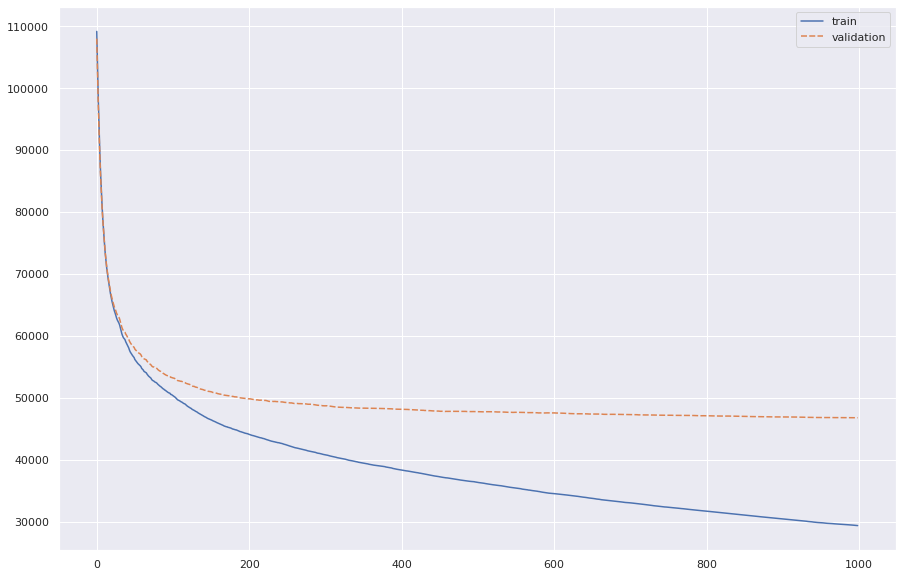

In [8]:
# we have to visualize learning curve manually :(
def plot_learning_curve(clf, X_train, y_train, X_val, y_val, max_iteration):
    from sklearn.metrics import mean_squared_error

    train_losses = []
    val_losses = []
    for ntree_end in tqdm(range(1, max_iteration)):
        pred_y_train = clf.predict(X_train, ntree_end=ntree_end)
        pred_y_val = clf.predict(X_val, ntree_end=ntree_end)
        train_rmse = np.sqrt(mean_squared_error(y_train, pred_y_train))
        train_losses.append(train_rmse)
        val_rmse = np.sqrt(mean_squared_error(y_val, pred_y_val))
        val_losses.append(val_rmse)
    sns.lineplot(data=pd.DataFrame({'train': train_losses, 'validation': val_losses}))

plot_learning_curve(clf, X_train, y_train, X_val, y_val, 1000)

In [9]:
print(clf.get_best_iteration())

998


As we see, best iteration is close to the maximum (1000), it may indicate that the chosen searning rate is too low.
Try higher learning rate to show how learning curve looks like in case of overfitting.

0:	learn: 86818.7056245	test: 86482.3052868	best: 86482.3052868 (0)	total: 10.9ms	remaining: 10.8s
1:	learn: 74753.0545496	test: 75221.4304300	best: 75221.4304300 (1)	total: 19.9ms	remaining: 9.96s
2:	learn: 68430.4493983	test: 68976.2495990	best: 68976.2495990 (2)	total: 28.4ms	remaining: 9.43s
3:	learn: 65334.7527303	test: 65810.2769389	best: 65810.2769389 (3)	total: 36.4ms	remaining: 9.07s
4:	learn: 63388.2836680	test: 64228.4932682	best: 64228.4932682 (4)	total: 44ms	remaining: 8.76s
5:	learn: 62238.8027628	test: 63415.7454251	best: 63415.7454251 (5)	total: 53.7ms	remaining: 8.9s
6:	learn: 60860.5422244	test: 62370.7909962	best: 62370.7909962 (6)	total: 61.4ms	remaining: 8.7s
7:	learn: 58497.5258240	test: 60111.7681763	best: 60111.7681763 (7)	total: 68.9ms	remaining: 8.54s
8:	learn: 57488.0004448	test: 59569.9973262	best: 59569.9973262 (8)	total: 76.7ms	remaining: 8.45s
9:	learn: 56788.4109032	test: 59022.8468305	best: 59022.8468305 (9)	total: 83.4ms	remaining: 8.25s
10:	learn: 562

  0%|          | 0/999 [00:00<?, ?it/s]

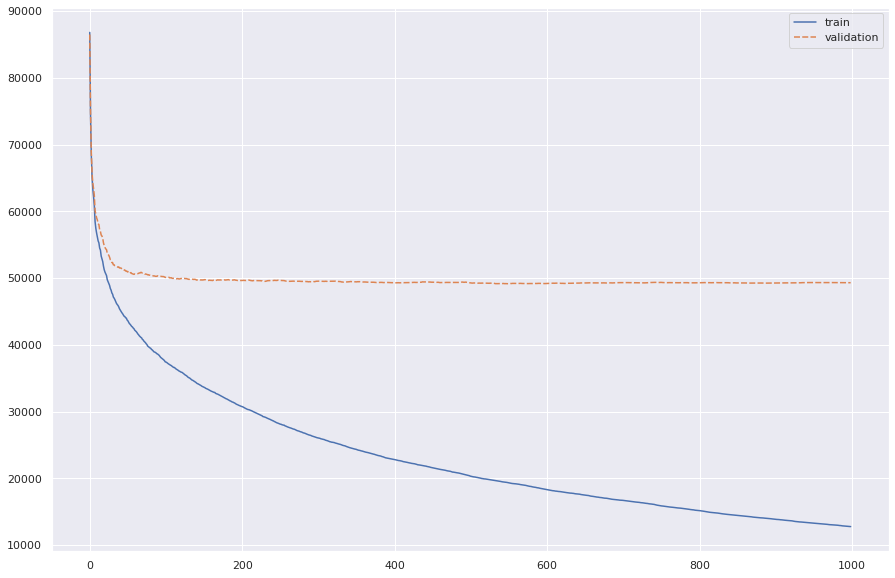

In [10]:
clf = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.5,
    use_best_model=False,
    random_seed=42,
)

clf.fit(
    X_train, y_train,
    cat_features=['ocean_proximity'],
    eval_set=(X_val, y_val),
    # plot=True,
)

plot_learning_curve(clf, X_train, y_train, X_val, y_val, 1000)

# Model selection. Cross-validation

Since CatBoost is not always compatible with sklearn interface (`.fit()` may accept more parameters for categorical features), it's not always possible to use standard sklearn methods.

However, essentially the main hyperparameter to choose is `learning_rate`. The number of trees (`iterations`) can be chosen from performance considerations (typical range is 1000-10000).

Therefore, we can perform grid search / random search manually. Also, `catboost` package provides tools for cross-validation (see the [documentation](https://catboost.ai/en/docs/concepts/python-reference_cv) for more details).

In [11]:
from catboost import Pool, cv
import numpy as np

cv_params = {
    'loss_function': 'RMSE',  # regression
    'random_seed': 42,
    'use_best_model': True,
    'iterations': 1000,
    'learning_rate': 0.5
}
cv_data = cv(
    Pool(X_train_val, y_train_val, cat_features=['ocean_proximity']),
    cv_params,
    verbose=False,
    seed=42,
    fold_count=3
)

Training on fold [0/3]

bestTest = 48306.64896
bestIteration = 404

Training on fold [1/3]

bestTest = 49204.8065
bestIteration = 345

Training on fold [2/3]

bestTest = 48940.37286
bestIteration = 276



The `cv` function calculates the average of `fold_count` metric values and the standard deviation. Thus, these two values are returned on each iteration.

In [12]:
cv_data

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
0,0,139962.607845,2568.576824,139813.892769,869.040894
1,1,97307.531230,2159.268568,96929.020325,680.914770
2,2,80408.166002,1510.102187,79875.741079,870.862008
3,3,71757.275291,1400.293163,70884.569169,725.170473
4,4,67100.042083,1520.052592,66185.990150,583.324913
...,...,...,...,...,...
995,995,49174.451314,581.872459,11073.461853,231.345974
996,996,49173.488611,578.502868,11063.753293,226.185927
997,997,49179.727494,575.486101,11055.859164,223.105058
998,998,49175.760552,574.748118,11038.137341,223.236853


In [13]:
print('Best validation RMSE score: {:.2f}±{:.2f} on step {}'.format(
    np.min(cv_data['test-RMSE-mean']),
    cv_data['test-RMSE-std'][np.argmin(cv_data['test-RMSE-mean'])],
    np.argmin(cv_data['test-RMSE-mean'])
))

Best validation RMSE score: 48898.13±490.76 on step 386


Now we are ready to do model selection.

In [14]:
cv_results = []
for learning_rate in tqdm(np.linspace(0.05, 0.7, 10)):
    cv_params = {
        'loss_function': 'RMSE',  # regression
        'random_seed': 42,
        'use_best_model': True,
        'iterations': 1000,
        'learning_rate': learning_rate
    }
    cv_data = cv(
        Pool(X_train_val, y_train_val, cat_features=['ocean_proximity']),
        cv_params,
        verbose=False,
        seed=42,
        fold_count=3
    )
    cv_score = np.min(cv_data['test-RMSE-mean'])
    cv_results.append((learning_rate, cv_score))

  0%|          | 0/10 [00:00<?, ?it/s]

Training on fold [0/3]

bestTest = 46735.89501
bestIteration = 999

Training on fold [1/3]

bestTest = 47095.45595
bestIteration = 997

Training on fold [2/3]

bestTest = 47519.84031
bestIteration = 999

Training on fold [0/3]

bestTest = 45997.45168
bestIteration = 992

Training on fold [1/3]

bestTest = 46312.18176
bestIteration = 999

Training on fold [2/3]

bestTest = 46605.0916
bestIteration = 998

Training on fold [0/3]

bestTest = 46121.02805
bestIteration = 896

Training on fold [1/3]

bestTest = 46690.78982
bestIteration = 971

Training on fold [2/3]

bestTest = 46801.7374
bestIteration = 987

Training on fold [0/3]

bestTest = 46773.97043
bestIteration = 847

Training on fold [1/3]

bestTest = 47360.5731
bestIteration = 615

Training on fold [2/3]

bestTest = 46863.66988
bestIteration = 593

Training on fold [0/3]

bestTest = 47531.35689
bestIteration = 396

Training on fold [1/3]

bestTest = 47031.22848
bestIteration = 968

Training on fold [2/3]

bestTest = 47253.00502
best

In [15]:
for learning_rate, cv_score in cv_results:
    print(f"Learning rate: {learning_rate}, cv score: {cv_score}")

Learning rate: 0.05, cv score: 47117.44262785234
Learning rate: 0.12222222222222222, cv score: 46312.150359287734
Learning rate: 0.19444444444444442, cv score: 46554.0660236734
Learning rate: 0.26666666666666666, cv score: 47020.3910667681
Learning rate: 0.33888888888888885, cv score: 47335.30468772792
Learning rate: 0.41111111111111104, cv score: 48272.15716714147
Learning rate: 0.4833333333333333, cv score: 48530.383081819105
Learning rate: 0.5555555555555556, cv score: 49628.69434123364
Learning rate: 0.6277777777777778, cv score: 50146.24667347793
Learning rate: 0.7, cv score: 50529.10450432248


Alternatively, we may use more advanced methods (compared to grid/random search), implemented in the `hyperopt` package.

Currently three algorithms are implemented in hyperopt:
- Random Search
- Tree of Parzen Estimators (TPE)
- Adaptive TPE

TPE is a sequential algorithm that leverages bayesian updating and follows the below sequence.

1. Train a model with several sets of randomly-selected hyperparameters, returning objective function values.
2. Split our observed objective function values into “good” and “bad” groups, according to some threshold gamma (γ).
3. Calculate the “promisingness” score, which is just P(x|good) / P(x|bad).
4. Determine the hyperparameters that maximize promisingness via mixture models.
5. Fit our model using the hyperparameters from step 4.
6. Repeat steps 2–5 until a stopping criteria.

(The explanation of TPE is borrowed from [towardsdatascience](https://towardsdatascience.com/hyperopt-demystified-3e14006eb6fa)).

In [16]:
import hyperopt

def hyperopt_objective(params):
    model = CatBoostRegressor(
        learning_rate=params['learning_rate'],
        iterations=1000,
        random_seed=42,
        verbose=False,
    )
    
    cv_data = cv(
        Pool(X_train_val, y_train_val, cat_features=['ocean_proximity']),
        model.get_params(),
        logging_level='Silent',
    )
    best_rmse = np.min(cv_data['test-RMSE-mean'])
    
    return best_rmse  # hyperopt minimises

In [17]:
from numpy.random import RandomState

params_space = {
    'learning_rate': hyperopt.hp.uniform('learning_rate', 0.05, 0.7),
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=10,
    trials=trials,
    rstate=RandomState(42)
)

print(best)

100%|██████████| 10/10 [04:15<00:00, 25.58s/it, best loss: 47912.08199723781]
{'learning_rate': 0.34555568394389186}


# Evaluate the model

In [ ]:
# evaluate as in the previous lecture. our best relative error was ~28% 
from sklearn.metrics import mean_squared_error
import numpy as np
clf = CatBoostRegressor(
    iterations=1000,
    learning_rate=best['learning_rate'],
    use_best_model=True,
    random_seed=42,
)

clf.fit(
    X_train, y_train,
    cat_features=['ocean_proximity'],
    eval_set=(X_val, y_val),
)

def print_training_report(clf, X_train, y_train, X_test, y_test):
    pred_y_train = clf.predict(X_train)
    pred_y_test = clf.predict(X_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, pred_y_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, pred_y_test))

    print("RMSE on train data: {} (relative error {:.1f}%)".format(train_rmse, 100 * train_rmse / np.mean(y_train)))
    print("RMSE on test data: {} (relative error {:.1f}%)".format(test_rmse, 100 * test_rmse / np.mean(y_train)))

print_training_report(clf, X_train_val, y_train_val, X_test, y_test)

# Early stopping

This feature is similar to `use_best_model`, but it doesn't require to run all iterations.
This saves time and doesn't drop quality.



In [19]:
# evaluate as in the previous lecture. our best relative error was ~28% 
from sklearn.metrics import mean_squared_error
import numpy as np
clf = CatBoostRegressor(
    iterations=10000,  # note that we can safely use 10000 trees instead of 1000
    learning_rate=best['learning_rate'],
    use_best_model=True,
    random_seed=42,
    # stop if there are 40 iterations without improvement on validation
    # "od" stands for "overfitting detector"
    od_type='Iter', od_wait=40,
)

clf.fit(
    X_train, y_train,
    cat_features=['ocean_proximity'],
    eval_set=(X_val, y_val),
)

print_training_report(clf, X_train_val, y_train_val, X_test, y_test)

0:	learn: 94513.5329627	test: 93878.7729714	best: 93878.7729714 (0)	total: 8.57ms	remaining: 1m 25s
1:	learn: 81870.3183462	test: 82154.1914427	best: 82154.1914427 (1)	total: 16ms	remaining: 1m 20s
2:	learn: 74865.9399162	test: 75098.7335304	best: 75098.7335304 (2)	total: 24.1ms	remaining: 1m 20s
3:	learn: 70670.9942107	test: 70991.7534907	best: 70991.7534907 (3)	total: 31.6ms	remaining: 1m 18s
4:	learn: 67733.6418148	test: 68344.5635653	best: 68344.5635653 (4)	total: 39ms	remaining: 1m 17s
5:	learn: 65913.6807536	test: 66526.0424059	best: 66526.0424059 (5)	total: 46.2ms	remaining: 1m 16s
6:	learn: 64293.5584509	test: 65112.6644701	best: 65112.6644701 (6)	total: 53.8ms	remaining: 1m 16s
7:	learn: 62898.7167131	test: 63978.8329409	best: 63978.8329409 (7)	total: 60.9ms	remaining: 1m 16s
8:	learn: 61667.8785319	test: 62941.1545484	best: 62941.1545484 (8)	total: 69ms	remaining: 1m 16s
9:	learn: 60275.7023971	test: 61634.5200451	best: 61634.5200451 (9)	total: 77.2ms	remaining: 1m 17s
10:	le

# Feature importances

Documentation is [here](https://catboost.ai/en/docs/en/features/feature-importances-calculation).

CatBoost provides different types of feature importance calculation:

- **PredictionValuesChange** (default for classification and regression)

  For each feature, PredictionValuesChange shows how much on average the prediction changes if the feature value changes. The bigger the value of the importance the bigger on average is the change to the prediction value, if this feature is changed.

  **Idea**: feature "sends" input objects into different leaves; compute "how much different" these leaves are.
- **LossFunctionChange** (default for ranking)

  For each feature the value represents the difference between the loss value of the model with this feature and without it. The model without this feature is equivalent to the one that would have been trained if this feature was excluded from the dataset. Since it is computationally expensive to retrain the model without one of the features, this model is built approximately using the original model with this feature removed from all the trees in the ensemble. 


In [20]:
feature_importances = clf.get_feature_importance(
    Pool(X_train_val, y_train_val, cat_features=['ocean_proximity']),
    prettified=True,  # return Pandas dataframe
)
feature_importances

,Feature Id,Importances
0,median_income,25.356329
1,longitude,17.696168
2,ocean_proximity,16.213952
3,latitude,15.990657
4,population,7.740989
5,housing_median_age,5.392601
6,total_rooms,4.367118
7,households,4.245724
8,total_bedrooms,2.996463


Visualization is better than tabular representation:

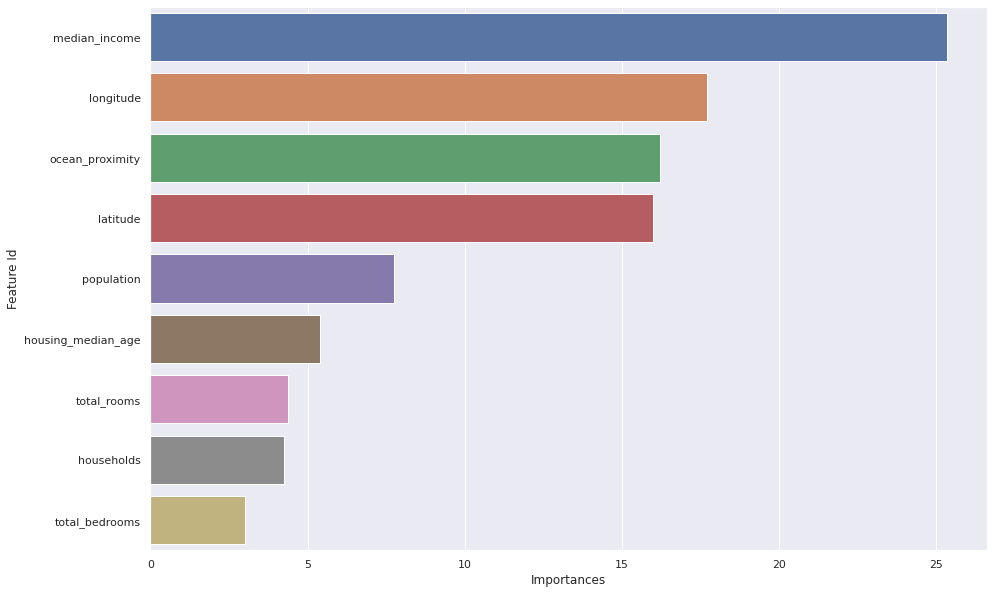

In [21]:
def visualize_feature_importances(clf, pool, feature_names):
    feature_importances = clf.get_feature_importance(pool, prettified=True)

    sns.barplot(x="Importances", y="Feature Id", data=feature_importances)

visualize_feature_importances(
    clf,
    Pool(X_train_val, y_train_val, cat_features=['ocean_proximity']),
    X_train_val.columns
)

# Features interaction
All splits of features $f_1$ and $f_2$ in all trees of the resulting ensemble are observed when calculating the interaction between these features.

If splits of both features are present in the tree, then we are looking on how much leaf value changes when these splits have the same value and they have opposite values.

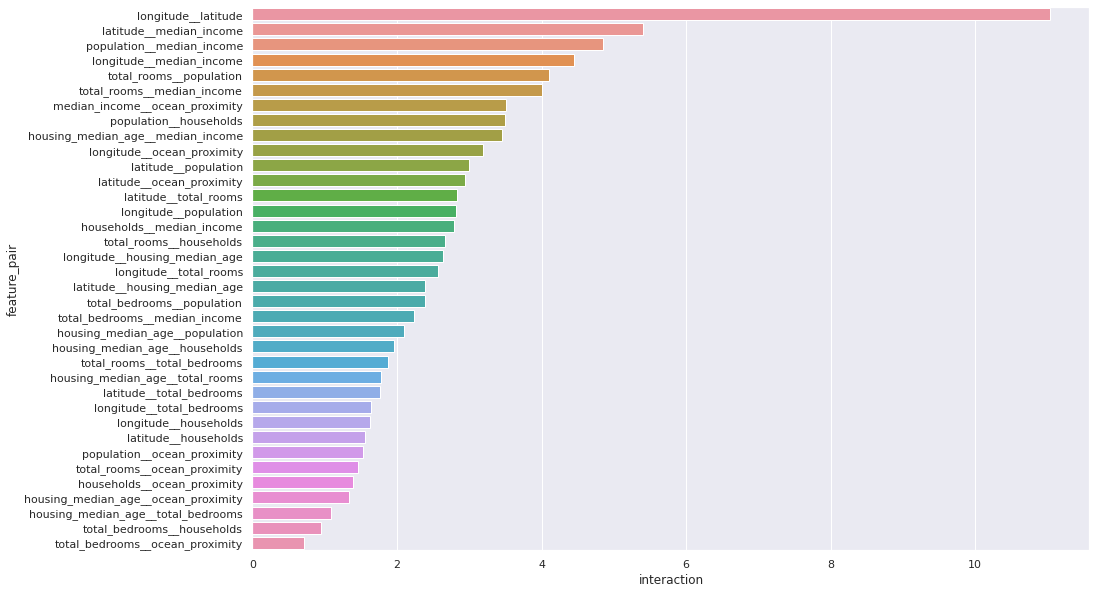

In [22]:
def visualize_feature_interactions(clf, pool, feature_names):
    feature_interactions = clf.get_feature_importance(pool, type="Interaction")

    interactions = []
    feature_pairs = []
    for fi in feature_interactions:
        interactions.append(fi[2])
        feature_pairs.append(feature_names[int(fi[0])] + '__' + feature_names[int(fi[1])])
    feature_interactions_df = pd.DataFrame({
        'interaction': interactions,
        'feature_pair': feature_pairs,
    })

    sns.barplot(x="interaction", y="feature_pair", data=feature_interactions_df)

visualize_feature_interactions(
    clf,
    Pool(X_train_val, y_train_val, cat_features=['ocean_proximity']),
    X_train_val.columns
)

# Feature analysis charts

Documentation is [here](https://catboost.ai/en/docs/en/concepts/feature-analysis-graph).

Provides a calculated and plotted set of statistics for the chosen feature.

An example of plotted statistics (unfortunately, doesn't work in Google Colab):
![](https://catboost.ai/docs-assets/catboost/1d87531b3fa9e620ed1c21f699eeeabf3255ef03/en/images/calc_feature_statistics__adult.png)

The X-axis of the resulting chart contains values of the feature divided into buckets. For numerical features, the splits between buckets represent conditions (`feature < value`) from the trees of the model. For categorical features, each bucket stands for a category.

The Y-axis of the resulting chart contains the following graphs:

- Average target (label) value in the bucket.

- Average prediction in the bucket.

- Number of objects in the bucket.

- Average predictions on varying values of the feature.

  To calculate it, the value of the feature is successively changed to fall into every bucket for every input object. The value for a bucket on the graph is calculated as the average for all objects when their feature values are changed to fall into this bucket.

In [23]:
feature_statistics = clf.calc_feature_statistics(Pool(X_train, y_train, cat_features=['ocean_proximity']), feature='median_income', plot=False)

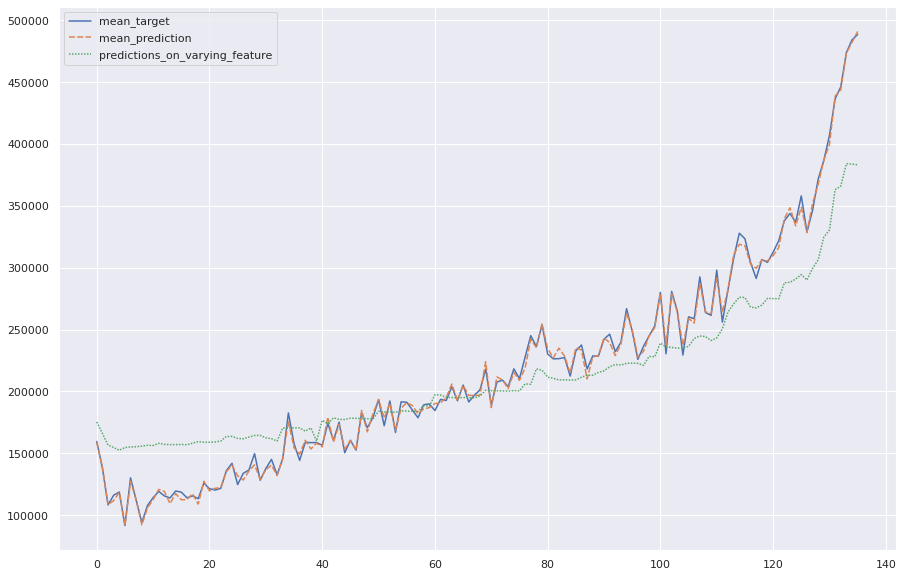

In [24]:
# in Google Colab, we have to reproduce original CatBoost plots :(
feature_statistics_df = pd.DataFrame({
    'mean_target': feature_statistics['mean_target'],
    'mean_prediction': feature_statistics['mean_prediction'],
    'predictions_on_varying_feature': feature_statistics['predictions_on_varying_feature'],
})
sns.lineplot(data=feature_statistics_df)

# Feature evaluation

The idea of feature evaluation algorithm:
- Split the dataset into train and test
- Train *two models*: one with the feature and one without it
- Evaluate both models
- Repeat the process a few times
- Estimate *statistical significance* of the difference between models *with* and *without the feature. If there is a statistically significant improvement -- the feature is good.

Pipeline for feature evaluation works as follows:

1. Choose fold size, this step is task-dependent. One should use fold size which will guarantee representative sample of general population. We suggest to use at most 50% of dataset as fold size, because otherwise it'll be easier to overfit on all dataset.
1. Estimate proper learning params. If we have representative sample, this params should be consistent for different folds. For feature evaluation one doesn't not need to tune all params, just the main ones: learning rate and ensemble size.
1. Train models on each fold and compute test metrics on the rest rest dataset. For big dataset test fold could be much bigger than learn. Such datasets should provide more stable results.


In [25]:
# the tool works with files only, so we need to prepare
from catboost.utils import create_cd
import os

dataset_dir = os.path.join('..', 'california_housing_prices')
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

train_file = os.path.join(dataset_dir, 'train.csv')
description_file = os.path.join(dataset_dir, 'train.cd')

df.to_csv(train_file, header=False, index=False)

feature_names = dict()
label_column = [i for i, f in enumerate(df.columns) if f == 'median_house_value'][0]
for column, name in enumerate(df):
    if column == label_column:
        continue
    feature_names[column] = name

create_cd(
    label=label_column, 
    cat_features=[i for i, f in enumerate(df.columns) if f == 'ocean_proximity'],
    feature_names=feature_names,
    output_path=os.path.join(dataset_dir, 'train.cd')
)
!cat $description_file

0	Num	longitude
1	Num	latitude
2	Num	housing_median_age
3	Num	total_rooms
4	Num	total_bedrooms
5	Num	population
6	Num	households
7	Num	median_income
8	Label	
9	Categ	ocean_proximity


In [82]:
train_file

'../california_housing_prices/train.csv'

These are parameters of the estimation procedure

In [26]:
fold_size = 6000
fold_offset = 0
folds_count = 20
random_seed = 0 

These are parameters of classifier whic will be trained and evaluated on each iteration

In [27]:
learn_params = {'iterations': 200, 
                'random_seed': 0, 
                'logging_level': 'Silent',
                'loss_function': 'RMSE',}

In [28]:
features_to_evaluate = [
    7,  # median_income
    8,  # ocean_proximity (note that Label index in column description is ignored)
    6,  # households
]


In [29]:
from catboost.eval.catboost_evaluation import CatboostEvaluation
evaluator = CatboostEvaluation(train_file,
                               fold_size,
                               folds_count,
                               delimiter=',',
                               column_description=description_file,
                               partition_random_seed=random_seed,
)

In [30]:
result = evaluator.eval_features(learn_config=learn_params,
                                 eval_metrics=["RMSE"],
                                 features_to_eval=features_to_evaluate)

In [31]:
rmse_result = result.get_metric_results("RMSE")
rmse_result.get_baseline_comparison()

,PValue,Score,Quantile 0.005,Quantile 0.995,Decision,Overfit iter diff,Overfit iter pValue
Features: 7,0.000089,7.412082,7.058472,7.724776,GOOD,-0.9,0.312500
Features: 6,0.073138,0.337209,-0.145004,0.732091,UNKNOWN,0.1,0.640625
Features: 8,0.478125,0.090898,-0.369869,0.467114,UNKNOWN,0.1,0.742188


As we see, the strongest feature (according to feature importance) `median_income` is also good (Decision=GOOD), the weakest (`households`) is of unknown significance, as well as `ocean_proximity` (it is also good, but depends on `longitude` and `latitude`).

# Home assignment

## Exercise 1 (4 points)

Compare built-in categorical features support in CatBoost with manual one-hot encoding of `ocean_proximity` feature in California Housing Dataset.

In [36]:
clf = CatBoostRegressor(
    iterations=50,
    learning_rate=0.1,
    use_best_model=True,  # turn off to show full learning curve
    random_seed=42,
)

clf.fit(
    X_train, y_train,
    cat_features=['ocean_proximity'],
    eval_set=(X_val, y_val),
    verbose =False
    # plot=True,
)
print_training_report(clf, X_train_val, y_train_val, X_test, y_test)

RMSE on train data: 57134.70208404949 (relative error 27.6%)
RMSE on test data: 58868.82671914726 (relative error 28.5%)


In [80]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
preprocessor = make_column_transformer(
    (OneHotEncoder(), ['ocean_proximity']),
    remainder='passthrough'
)

X_train_encoded = preprocessor.fit_transform(X_train)
X_val_encoded = preprocessor.transform(X_val)
X_test_encoded = preprocessor.transform(X_test)
clf.fit(
    X_train_encoded, y_train,
    eval_set=(X_val_encoded, y_val),
    verbose =False
    # plot=True,
)
print_training_report(clf, X_val_encoded, y_val, X_test_encoded, y_test)

RMSE on train data: 58115.442868837104 (relative error 28.2%)
RMSE on test data: 58327.43936222899 (relative error 28.3%)


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(X_train_encoded.shape)
print(X_test_encoded.shape)
print(X_val_encoded.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

## Exercise 2 (2 points)

Evaluate features `rooms_per_household` and `bedrooms_per_household`, defined in the previous lesson. Here is [the link](https://colab.research.google.com/drive/1_iqno_GkKfaQMIh5QmICu0-WC50hWPF3#scrollTo=_OecU0VmNKxs) for your convenience.

In [83]:
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_household'] = df['total_bedrooms'] / df['households']

In [84]:
# the tool works with files only, so we need to prepare
from catboost.utils import create_cd
import os

dataset_dir = os.path.join('..', 'california_housing_prices')
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

train_file = os.path.join(dataset_dir, 'train.csv')
description_file = os.path.join(dataset_dir, 'train.cd')

df.to_csv(train_file, header=False, index=False)

feature_names = dict()
label_column = [i for i, f in enumerate(df.columns) if f == 'median_house_value'][0]
for column, name in enumerate(df):
    if column == label_column:
        continue
    feature_names[column] = name

create_cd(
    label=label_column, 
    cat_features=[i for i, f in enumerate(df.columns) if f == 'ocean_proximity'],
    feature_names=feature_names,
    output_path=os.path.join(dataset_dir, 'train.cd')
)
!cat $description_file

0	Num	longitude
1	Num	latitude
2	Num	housing_median_age
3	Num	total_rooms
4	Num	total_bedrooms
5	Num	population
6	Num	households
7	Num	median_income
8	Label	
9	Categ	ocean_proximity
10	Num	rooms_per_household
11	Num	bedrooms_per_household


In [92]:
fold_size = 6000
fold_offset = 0
folds_count = 20
random_seed = 0 
learn_params = {'iterations': 200, 
                'random_seed': 0, 
                'logging_level': 'Silent',
                'loss_function': 'RMSE',}
features_to_evaluate = [
    9, #rooms_per_household
    10,  # bedrooms_per_household
]


In [93]:
from catboost.eval.catboost_evaluation import CatboostEvaluation
evaluator = CatboostEvaluation(train_file,
                               fold_size,
                               folds_count,
                               delimiter=',',
                               column_description=description_file,
                               partition_random_seed=random_seed,
)

In [94]:
result = evaluator.eval_features(learn_config=learn_params,
                                 eval_metrics=["RMSE"],
                                 features_to_eval=features_to_evaluate)
rmse_result = result.get_metric_results("RMSE")
rmse_result.get_baseline_comparison()

,PValue,Score,Quantile 0.005,Quantile 0.995,Decision,Overfit iter diff,Overfit iter pValue
Features: 9,0.027621,0.342962,-0.005399,0.684368,UNKNOWN,0.85,0.007812
Features: 10,0.005734,-0.513148,-0.892792,-0.168541,BAD,0.60,0.203613


**As we can see rooms_per_household is not an important feature and bedrooms_per_household is a bad feature so better not to include it in the model.**